# Checking heritability computed on DNAm

In [8]:
library(here)
library(data.table)
library(parallel)
library(glue)

probe,V(G),V(e),Vp,V(G)/Vp,logL,logL0,LRT,Pval,V(G)_SE,V(e)_SE,Vp_SE,V(G)/Vp_SE
<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
cg00000029,0.014699,0.176618,0.191317,0.076832,41.664,37.479,8.370,1.91e-03,0.010041,0.016250,0.017702,0.049899
cg00000108,0.336076,0.072536,0.408613,0.822481,90.523,-21.504,224.053,0.00e+00,0.069762,0.007647,0.069107,0.035863
cg00000109,0.000000,0.080807,0.080807,0.000001,148.617,148.617,0.000,5.00e-01,0.001653,0.007277,0.007129,0.020453
cg00000165,0.001287,0.106842,0.108129,0.011907,111.422,111.331,0.183,3.34e-01,0.003213,0.009780,0.009558,0.029633
cg00000236,0.001661,0.059108,0.060769,0.027332,186.183,185.565,1.236,1.33e-01,0.002108,0.005383,0.005415,0.034262
cg00000289,0.050336,0.071638,0.121974,0.412679,129.968,105.339,49.257,1.12e-12,0.015407,0.007401,0.015317,0.084071


[1] 164434

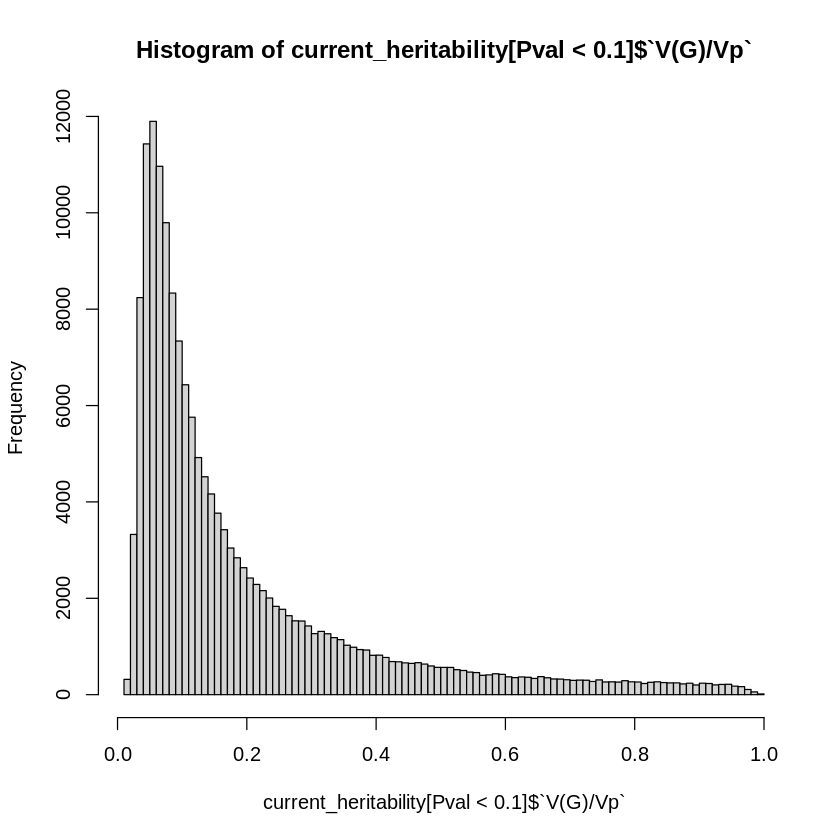

In [2]:
if(file.exists(here("data","cis_heritability.txt.gz"))){
    current_heritability <- fread(here("data","cis_heritability.txt.gz"))
}else{
    h_files <- dir(here("data", "gcta_analysis", "delahaye_output"))
    cpgs <- gsub(".hsq", "", h_files)

    read_heritability <- function(fname){
        dt <- fread(fname,fill=TRUE)
        main_cols <- transpose(dt[1:8,c(2)])
        colnames(main_cols) <- dt$Source[1:8]
        se_cols <- transpose(dt[1:4,c(3)])
        colnames(se_cols) <- paste0(dt$Source[1:4],"_SE")
        return(cbind(data.table(probe=gsub(".*/(.*).hsq","\\1",fname)),main_cols,se_cols))
    }
    current_heritability <- rbindlist(
        mclapply(
            here("data","gcta_analysis","delahaye_output",h_files),
            read_heritability,
            mc.cores = 32
        )
    )
   fwrite(current_heritability,here("data","cis_heritability.txt.gz"),sep='\t',quote=FALSE,row.names=FALSE)
}

head(current_heritability)

nrow(current_heritability[Pval < 0.10])
hist(current_heritability[Pval < 0.10]$`V(G)/Vp`,breaks=100)

## Create mQTL annotation filtering CAVIAR results with heritable CpGs

In [14]:
generate_annotation <- function(mQTL_annot, baseline_annot_f,chrom,annot){
    baseline_annot <- fread(baseline_annot_f)
    tmp <- mQTL_annot[current_heritability[Pval < 0.1]$probe,on="probe"][CHR == chrom]
    if(annot == "bin_CPP"){
        merged <- merge(
            baseline_annot,
            tmp[,.(bin_CPP=ifelse(any(CPP>0),1,0)),by="SNP"],
            by="SNP",all.x=TRUE,sort = FALSE)
        merged[, `:=`(bin_CPP = ifelse(is.na(bin_CPP),0,bin_CPP))]
        return(merged[,.(CHR,BP,SNP,CM,bin_CPP)])    
    }else if(annot == "maxCPP"){
        merged <- merge(
            baseline_annot,
            tmp[,.(maxCPP=max(CPP)),by="SNP"],
               by="SNP",all.x=TRUE,sort = FALSE)
        merged[, `:=`(maxCPP = ifelse(is.na(maxCPP),0,maxCPP))]
        return(merged[,.(CHR,BP,SNP,CM,maxCPP)])    
    }else if (annot == "all_cis"){ # @todo Edit this for final threshold table
        merged <- merge(
            baseline_annot,
            tmp[,.(all_cis=ifelse(any(FDR < 0.05),1,0)),by="SNP"],by="SNP",all.x=TRUE,sort = FALSE)
        merged[, `:=`(all_cis = ifelse(is.na(all_cis),0,all_cis))]
        return(merged[,.(CHR,BP,SNP,CM,all_cis)])    
        
    }else{
        print("NO ANNOTATION SELECTED")
        return(NULL)
    }
}

# build all annotations except male and female specific
for(annot in c("bin_cpp","maxCPP")){
    for(cur_mqtl in c("marginal","sex_interaction","male","female", "cord_mqtl")){
        mQTL_annot <- fread(glue("../data/{cur_mqtl}_meta_caviar_maf01.txt.gz"))
        cur_annot <- mclapply(
            1:22,
            function(i){
                generate_annotation(
                    mQTL_annot,
                    glue("../../1000G_v2.2_baseline/baselineLD.{i}.annot.gz"),
                    glue("{i}"),
                    "bin_CPP"
                )
            },
            mc.cores=16
        ) 
        mclapply(1:22, function(i)
            fwrite(
                cur_annot[[i]],
                glue("/scratch/st-dennisjk-1/wcasazza/1000G_phase3_ldsc/single_delahaye_annotations/{cur_mqtl}_{cur_annot}_her.{i}.annot.gz"),
                sep='\t',quote=FALSE,row.names=FALSE
            ),
            mc.cores=16
        )
    }
}